In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')
sys.path.append('./DNA_utils/')

In [ ]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.lines import Line2D
import itertools
%matplotlib inline

In [3]:
# load pre-trained RBM and pre-compute the partition functions
path = './trained_RBMs/'
file_name = 'myrbm-leftright-8th-all_data.data'
RBM_lr_0 = RBM_utils.loadRBM(path + file_name)
RBM_lr_0.AIS(n_betas=40000,verbose=0)

Mismatch dimensions (500, 70), [10, 70], reinitializating I
Mismatch dimensions (500, 20, 4), [10, 20, 4], reinitializating I


(96.84474, 0.017163609081373127)

In [4]:
# load round 8 data
path = './data/'
filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_8 = all_data_8.shape[0]
seq_len_8 = all_data_8.shape[1]
print('Dataset #8 shape =', all_data_8.shape)
full_data_8 = np.repeat(all_data_8, counts_8, axis=0)

# split left and right data
seqs_8_l_2num, counts_8_l = np.unique(full_data_8[:, :20], return_counts=True, axis=0)
all_data_8_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_l_2num),
                             'counts' : counts_8_l})

seqs_8_r_2num, counts_8_r = np.unique(full_data_8[:, 20:], return_counts=True, axis=0)
all_data_8_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_r_2num),
                             'counts' : counts_8_r})

# put both rounds together
all_data_8_lr = pd.concat([all_data_8_l, all_data_8_r])
all_data_8_lr = all_data_8_lr.reset_index(drop=True)
all_data_8_lr = all_data_8_lr.groupby(by=["sequence"], as_index=False).sum()
all_data_8_lr = all_data_8_lr.sort_values(by='counts', ascending=False).reset_index(drop=True)
all_seq_8_lr = DNA_utils.seq2num(all_data_8_lr["sequence"].to_list())
counts_8_lr = all_data_8_lr['counts'].to_numpy()

Dataset #8 shape = (719413, 40)


In [5]:
# compute loglikelihood for round 8 sequences
all_data_8_lr['loglikelihood'] = RBM_lr_0.likelihood(all_seq_8_lr)

In [6]:
# load experimental data
filename = './data/Aptamer_Exp_Results.csv'
exp_df = pd.read_csv(filename)
exp_rounds = []
for l in exp_df['label']:
    if 'd' in l:
        exp_rounds.append(1)
    elif ('r' in l) and (int(l[1:]) <= 23):
        exp_rounds.append(2)
    elif 'p' in l:
        exp_rounds.append(3)
    else:
        exp_rounds.append(4)
exp_df['experimental_round'] = exp_rounds
# add ThA with exp round -1
t_df = pd.DataFrame({"label":["ThA"], "sequence":["AGGGATGATGTGTGGTAGGC"], 
                     "binder":["B"],"binding site":["AB"], "experimental_round":[-1]})
exp_df = pd.concat([t_df, exp_df])
# create 3 dataset: general binders and AB and CD specific binders, only rounds -1, 2 and 3 (so ThX, r<23, and p sequences)
allowed_rounds = [-1, 2, 3]
df_binders_AB = exp_df[(exp_df['experimental_round'].isin(allowed_rounds)) & (exp_df['binding site']=='AB')]
df_binders_CD = exp_df[((exp_df['experimental_round']==2) | (exp_df['experimental_round']==3)) & (exp_df['binding site']=='CD')]

In [7]:
# compute inputs to HUs
beta = RBM_utils.get_norm(RBM_lr_0.weights)
order = np.argsort(beta)[::-1]
I_lr_c  = RBM_lr_0.input_hiddens(all_seq_8_lr)

In [8]:
# prepare aptamers from families in the Zhou et al.'s (10.1002/cbic.201900265) work, and sort weights by norm
fam_models = {
    'A':['AGGGATGATGTGTGGTAGGC', 'AGGGTTGATGTGTGGTAGGC', 'AGGGATGATGCGTGGTAGGC'],
    'B':['AGGGTAGGTGTGGATGATGC', 'AGGGTAGGCGTGGATGATGC', 'AGGGTAGGAGTGGATGATGC', 'AGGGTAGGGGTGGATGATGC'],
    'C':['TAGGTTTTGGGTAGGGTGGT', 'TAGGTTATGGGTAGGGTGGT', 'TAGGTCTTGGGTAGGGTGGT', 'TAGGTGTTGGGTAGGGTGGT',
             'TAGGTTGTGGGTAGGGTGGT'],
    'D':['CTAGGTTGGGTAGGGTGGTG', 'CTAGGATGGGTAGGGTGGTG', 'GTAGGGTGGGTAGGGTGGTC', 'GTAGGTTGGGTAGGGTGGTC',
             'GTAGGATGGGTAGGGTGGTC', 'ATAGGATGGGTAGGGTGGTT', 'CTAGGGTGGGTAGGATGGTG', 'ATAGGTTGGGTAGGGTGGTT']
}

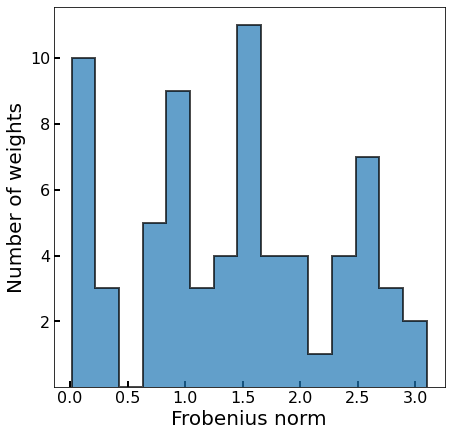

In [9]:
# histogram of weight norms
fig = plt.figure(figsize=(7, 7), constrained_layout=False)
gs = fig.add_gridspec(ncols=1, nrows=1, wspace=0.2)

ax2 = fig.add_subplot(gs[0,0])
ax2.hist(RBM_utils.get_norm(RBM_lr_0.weights), bins=15, histtype='step', 
         lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xlabel('Frobenius norm', fontsize=20)
ax2.set_ylabel('Number of weights', fontsize=20)
ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax2.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax2.tick_params(axis='both', labelsize=16)
ax2.set_yticks(np.array([2,4,6,8,10]));

In [10]:
# find paths connecting ThA and r9
tha = "AGGGATGATGTGTGGTAGGC"
r9 = "AGGGTTGGTGTGTGGTTGGC"

mutations_poss = [4, 7, 16]
def make_mut(mutpos, nowseq):
    """Make the mutation in position mutpos
    which mutates one of the ThA-like nt
    into one of the r9-like nts."""
    newseq = list(nowseq)
    if mutpos == 4:
        newseq[4] = "T"
    elif mutpos == 7:
        newseq[7] = "G"
    elif mutpos == 16:
        newseq[16] = "T"
    else:
        print("error!")
    return "".join(newseq)
mut_paths = list(itertools.permutations(mutations_poss))
seq_paths = []
lik_paths = []
for ms in mut_paths:
    t_seq = tha
    t_path = [tha]
    for m in ms:
        t_seq = make_mut(m, t_seq)
        t_path.append(t_seq)
    seq_paths.append(t_path)
    t_seqs2num = DNA_utils.seq2num(t_path)
    lik_paths.append(RBM_lr_0.likelihood(t_seqs2num))

In [11]:
# fix colors
fam_colors = {'A':'cyan', 'B':'purple', 'C': 'yellow', 'D':'dodgerblue', 'TBA_opt':'red', 'HD22_opt':'blue'}
fam_legends = {'A':'A', 'B':'B', 'C': 'C', 'D':'D'}
tested_colors = {"ThA":"lightcyan", "pathII":"limegreen", 
                 "r9":"mistyrose", "pathI":"salmon"}
mut_linestyles = {5:":", 8:"--", 17:"-"}

Text(0.5, 0, 'Position')

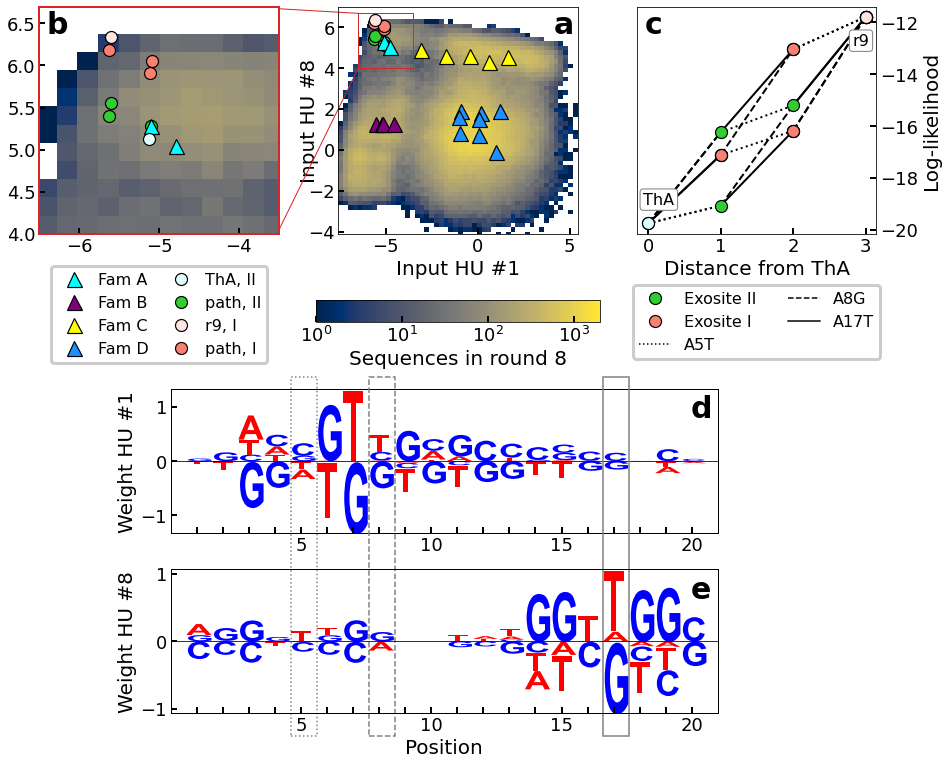

In [12]:
# make figure
fig = plt.figure(figsize=(15, 13))
gs = fig.add_gridspec(ncols=3, nrows=3, wspace=0.25, hspace=0.22, width_ratios = [1, 1, 1], height_ratios = [0.7, 0.2, 1])

# axlims of zoomin
xm = -6.5
xp = -3.5
ym = 4
yp = 6.7
zoomincol = 'C3'
highlight_ThA = True
highlight_ThA_to_r9 = True
highlight_r9 = True
highlight_ThA_to_r9 = True
############################################################################################################################
############################################################################################################################
############################################################################################################################
px = 0
py = 7
wx = order[px]
wy = order[py]
###################################################################
# main plot
ax = fig.add_subplot(gs[0,1])
# plot 2d hist for all 8th round dataset
I_lr_c  = RBM_lr_0.input_hiddens(all_seq_8_lr)
t_x = I_lr_c[:, wx]
t_y = I_lr_c[:, wy]
h2d = ax.hist2d(t_x, t_y, bins=50, cmap='cividis', norm=mcolors.LogNorm(vmin=1, vmax=2000))#min=1, vmax=20000))
# plot points for family members
for key in fam_models:
    I_fam_seq = RBM_lr_0.input_hiddens(DNA_utils.seq2num(fam_models[key]))
    t_x = I_fam_seq[:, wx]
    t_y = I_fam_seq[:, wy]
    if key == 'A':
        # in this case skip ThA
        ax.plot(t_x[1:], t_y[1:],'^', alpha=1, color=fam_colors[key], markeredgewidth=1.2,
                markeredgecolor="black", markersize=15, label=fam_legends[key], zorder=8)        
    else:
        ax.plot(t_x, t_y,'^', alpha=1, color=fam_colors[key], markeredgewidth=1.2,
                markeredgecolor="black", markersize=15, label=fam_legends[key], zorder=2)
# plot path
if highlight_ThA:
    ThA_seq2num = DNA_utils.seq2num(df_binders_AB[df_binders_AB['label']=='ThA']['sequence'].to_list())
    x_ThA = RBM_lr_0.input_hiddens(ThA_seq2num)[:, wx]
    y_ThA = RBM_lr_0.input_hiddens(ThA_seq2num)[:, wy]
    ax.plot(x_ThA, y_ThA, 'o', alpha=1, color=tested_colors["ThA"], markeredgewidth=1.2,
             markeredgecolor="black", markersize=12, label = 'ThA, II', zorder=5)
if highlight_ThA_to_r9: 
    path_seq2num = DNA_utils.seq2num(df_binders_AB[[x[0]=='p' for x in df_binders_AB['label']]]['sequence'].to_list())
    x_path = RBM_lr_0.input_hiddens(path_seq2num)[:, wx]
    y_path = RBM_lr_0.input_hiddens(path_seq2num)[:, wy]
    ax.plot(x_path, y_path, 'o', alpha=1, color=tested_colors["pathII"], markeredgewidth=1.2,
             markeredgecolor="black", markersize=12, label = 'path, II') 
if highlight_r9:
    r9_seq2num = DNA_utils.seq2num(df_binders_CD[df_binders_CD['label']=='r9']['sequence'].to_list())
    x_r9 = RBM_lr_0.input_hiddens(r9_seq2num)[:, wx]
    y_r9 = RBM_lr_0.input_hiddens(r9_seq2num)[:, wy]
    ax.plot(x_r9, y_r9, 'o', alpha=1, color=tested_colors["r9"], markeredgewidth=1.2,
             markeredgecolor="black", markersize=12, label = 'r9, I', zorder=5)
if highlight_ThA_to_r9:
    path_seq2num = DNA_utils.seq2num(df_binders_CD[[x[0]=='p' for x in df_binders_CD['label']]]['sequence'].to_list())
    x_path = RBM_lr_0.input_hiddens(path_seq2num)[:, wx]
    y_path = RBM_lr_0.input_hiddens(path_seq2num)[:, wy]
    ax.plot(x_path, y_path, 'o', alpha=1, color=tested_colors["pathI"], markeredgewidth=1.2,
             markeredgecolor="black", markersize=12, label = 'path, I') 
ax.set_ylabel('Input HU #' + str(py+1), fontsize=20)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.set_xlabel('Input HU #' + str(px+1), fontsize=20)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='out', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_ylim((-4.1, 7))
ax.text(0.9, 0.88, 'a', fontsize=30, 
         color='k', weight='bold', transform=ax.transAxes)
###################################################################
# colorbar
#fax = fig.add_subplot(gs[1,:])
tt_gs = gs[1, :].subgridspec(ncols=3, nrows=3, wspace=0.2, hspace=0., width_ratios=[0.8, 1, 0.8])
ax_cb = fig.add_subplot(tt_gs[1, 1])
fig.colorbar(h2d[3], cax=ax_cb, orientation='horizontal') 
ax_cb.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax_cb.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax_cb.tick_params(axis='both', labelsize=18)
ax_cb.set_xlabel('Sequences in round 8', fontsize=20)
##################
# square patch and lines
rect = patches.Rectangle((xm, ym), xp-xm, yp-ym, linewidth=1, edgecolor=zoomincol, facecolor='none')
ax.add_patch(rect)
ax.add_artist(lines.Line2D([-10.9, xm], [6.9, yp-0.03], color=zoomincol, lw=1, clip_on = False))
ax.add_artist(lines.Line2D([-10.9, xm], [-4.05, ym], color=zoomincol, lw=1, clip_on = False))
############################################################################################################################
############################################################################################################################
############################################################################################################################
### plot as before, but now with data from experiment
ax1 = fig.add_subplot(gs[0,0])
# plot 2d hist for all 8th round dataset
I_lr_c  = RBM_lr_0.input_hiddens(all_seq_8_lr)
t_x = I_lr_c[:, wx]
t_y = I_lr_c[:, wy]
h2d = ax1.hist2d(t_x, t_y, bins=50, cmap='cividis', norm=mcolors.LogNorm(vmin=1, vmax=2000))#min=1, vmax=20000))
# plot points for family members
for key in fam_models:
    I_fam_seq = RBM_lr_0.input_hiddens(DNA_utils.seq2num(fam_models[key]))
    t_x = I_fam_seq[:, wx]
    t_y = I_fam_seq[:, wy]
    if key == 'A':
        # in this case skip ThA
        ax1.plot(t_x[1:], t_y[1:],'^', alpha=1, color=fam_colors[key], markeredgewidth=1.2,
                markeredgecolor="black", markersize=15, label='Fam ' + fam_legends[key], zorder=4)        
    else:
        ax1.plot(t_x, t_y,'^', alpha=1, color=fam_colors[key], markeredgewidth=1.2,
                markeredgecolor="black", markersize=15, label='Fam ' + fam_legends[key], zorder=2)
# plot path
if highlight_ThA:
    ThA_seq2num = DNA_utils.seq2num(df_binders_AB[df_binders_AB['label']=='ThA']['sequence'].to_list())
    x_ThA = RBM_lr_0.input_hiddens(ThA_seq2num)[:, wx]
    y_ThA = RBM_lr_0.input_hiddens(ThA_seq2num)[:, wy]
    ax1.plot(x_ThA, y_ThA, 'o', alpha=1, color=tested_colors["ThA"], markeredgewidth=1.2,
             markeredgecolor="black", markersize=12, label = 'ThA, II', zorder=5)
if highlight_ThA_to_r9: 
    path_seq2num = DNA_utils.seq2num(df_binders_AB[[x[0]=='p' for x in df_binders_AB['label']]]['sequence'].to_list())
    x_path = RBM_lr_0.input_hiddens(path_seq2num)[:, wx]
    y_path = RBM_lr_0.input_hiddens(path_seq2num)[:, wy]
    ax1.plot(x_path, y_path, 'o', alpha=1, color=tested_colors["pathII"], markeredgewidth=1.2,
             markeredgecolor="black", markersize=12, label = 'path, II')
if highlight_r9:
    r9_seq2num = DNA_utils.seq2num(df_binders_CD[df_binders_CD['label']=='r9']['sequence'].to_list())
    x_r9 = RBM_lr_0.input_hiddens(r9_seq2num)[:, wx]
    y_r9 = RBM_lr_0.input_hiddens(r9_seq2num)[:, wy]
    ax1.plot(x_r9, y_r9, 'o', alpha=1, color=tested_colors["r9"], markeredgewidth=1.2,
             markeredgecolor="black", markersize=12, label = 'r9, I', zorder=5)
if highlight_ThA_to_r9:
    path_seq2num = DNA_utils.seq2num(df_binders_CD[[x[0]=='p' for x in df_binders_CD['label']]]['sequence'].to_list())
    x_path = RBM_lr_0.input_hiddens(path_seq2num)[:, wx]
    y_path = RBM_lr_0.input_hiddens(path_seq2num)[:, wy]
    ax1.plot(x_path, y_path, 'o', alpha=1, color=tested_colors["pathI"], markeredgewidth=1.2,
             markeredgecolor="black", markersize=12, label = 'path, I')
l = ax1.legend(framealpha=1, fontsize=16, ncol=2, loc=(0.05, -0.57),
              columnspacing=1, handletextpad=0.5)
l.get_frame().set_linewidth(3)
ax1.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax1.tick_params(which='minor', direction='out', length=0, width=2, colors='k')
ax1.tick_params(axis='both', labelsize=18)
ax1.set_xlim((xm, xp))
ax1.set_ylim((ym, yp))
for spine in ax1.spines.values():
        spine.set_edgecolor(zoomincol)
        spine.set_linewidth(2)
ax1.text(0.03, 0.88, 'b', fontsize=30, 
         color='k', weight='bold', transform=ax1.transAxes)
############################################################################################################################
############################################################################################################################
############################################################################################################################
ax2 = fig.add_subplot(gs[0,2])
x = [0,1,2,3]
# plot all points
tv = (np.array(lik_paths).T)
upoints = [np.unique(x) for x in tv]
for i, y in enumerate(upoints):
    xx = [x[i] for _ in range(len(y))]
    ax2.plot(xx, y, 'o', markersize=12, markeredgewidth=1.2, markeredgecolor='k', color=tested_colors["pathII"])
for i, y in enumerate(lik_paths):
    changeflag = False
    for j, m in enumerate(mut_paths[i]):
        tx = [x[j], x[j+1]]
        ty = [y[j], y[j+1]]
        
        xx = x[j+1]
        yy = y[j+1]
        if m == 16:
            changeflag = True
        if m == 4:
            ax2.plot(tx, ty, mut_linestyles[5], linewidth=2, color='k', zorder=-1)
        elif m == 7:
            ax2.plot(tx, ty, mut_linestyles[8], linewidth=2, color='k', zorder=-1)
        elif m == 16:
            ax2.plot(tx, ty, mut_linestyles[17], linewidth=2, color='k', zorder=-1)
        if changeflag:
            ax2.plot(xx, yy, 'o', markersize=12, markeredgewidth=1.2, markeredgecolor='k', color=tested_colors["pathI"])
ax2.set_xticks([0,1,2,3])
ax2.set_ylabel("Log-likelihood", size=20)
ax2.set_xlabel("Distance from ThA", size=20)
# ThA
ax2.plot(x[0], lik_paths[0][0], 'o', markersize=12, markeredgewidth=1.2, markeredgecolor='k',
         color=tested_colors["ThA"])
# r9
ax2.plot(x[-1], lik_paths[0][-1], 'o', markersize=12, markeredgewidth=1.2, markeredgecolor='k',
         color=tested_colors["r9"])
# legend
legend_elements = [Line2D([0], [0], marker='o', markersize=12, markeredgewidth=1.2, 
                          markeredgecolor='k', label='Exosite II', color = tested_colors["pathII"], linewidth=0),
                   Line2D([0], [0], marker='o', markersize=12, markeredgewidth=1.2, 
                          markeredgecolor='k', label='Exosite I', color = tested_colors["pathI"], linewidth=0),
                   Line2D([0], [0], linestyle=mut_linestyles[5],  label='A5T' , color = 'k'),
                   Line2D([0], [0], linestyle=mut_linestyles[8], label='A8G' , color = 'k'),
                   Line2D([0], [0], linestyle=mut_linestyles[17],  label='A17T', color = 'k'),
                  ]
l = ax2.legend(handles=legend_elements, ncol=2, framealpha=1, fontsize=16, loc=(-0.02, -0.55))
l.get_frame().set_linewidth(3)
ax2.text(0.025, 0.15, 'ThA', horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes,
             fontsize=16, bbox=dict(boxstyle="round, pad=0.2", fc="white", ec="gray", lw=1))
ax2.text(0.9, 0.85, 'r9', horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes,
             fontsize=16, bbox=dict(boxstyle="round, pad=0.2", fc="white", ec="gray", lw=1))
ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax2.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax2.tick_params(axis='both', labelsize=18)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.text(0.03, 0.88, 'c', fontsize=30, 
         color='k', weight='bold', transform=ax2.transAxes)
############################################################################################################################
############################################################################################################################
############################################################################################################################
t_gs = gs[2, :].subgridspec(ncols=3, nrows=2, hspace=0.25, width_ratios=[0.15, 1, 0.2])
ps = [0, 7]
panel_labels = ['d', 'e']
for i,p in enumerate(ps):    
    w = order[p]
    t_ax = fig.add_subplot(t_gs[i,1])
    t_ax.hlines(0, -1, 21, color='k', lw=0.8)
    DNA_sequence_logo.Sequence_logo(RBM_lr_0.weights[w], ax=t_ax, ylabel = "Weight HU #"+str(p+1), title='', 
                                    ticks_every=5, ticks_labels_size=12, title_size=20, show=False)
    [t_ax.spines[x].set_linewidth(1) for x in t_ax.spines.keys()]
    t_ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
    t_ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
    t_ax.tick_params(axis='both', labelsize=18)
    t_ax.spines['right'].set_visible(True)
    t_ax.spines['top'].set_visible(True)
    t_ax.text(0.95, 0.8, panel_labels[i], fontsize=30, 
              color='k', weight='bold', transform=t_ax.transAxes)
# box for the mutations
rect1 = patches.Rectangle((4.6, -1.4), 1, 5.3, linewidth=1.5, edgecolor='gray', linestyle=mut_linestyles[5],
                          facecolor='none', clip_on=False)
rect2 = patches.Rectangle((7.6, -1.4), 1, 5.3, linewidth=1.5, edgecolor='gray', linestyle=mut_linestyles[8],
                          facecolor='none', clip_on=False)
rect3 = patches.Rectangle((16.6, -1.4), 1, 5.3, linewidth=1.5, edgecolor='gray', linestyle=mut_linestyles[17],
                          facecolor='none', clip_on=False)
t_ax.add_patch(rect1)
t_ax.add_patch(rect2)
t_ax.add_patch(rect3)
t_ax.set_xlabel("Position", fontsize=20)